 Load Data, Preprocess Text, Encode Labels, and Split

In [3]:
import pandas as pd
import numpy as np
import nltk
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import sys # Import sys to use sys.exit()

# --- Download NLTK data (if not already done) ---
print("Checking for NLTK resources...")
try:
    nltk.data.find('corpora/wordnet')
    print("- NLTK 'wordnet' found.")
except LookupError: # Corrected exception type
    print("NLTK 'wordnet' not found. Attempting download...")
    nltk.download('wordnet')
try:
    nltk.data.find('corpora/stopwords')
    print("- NLTK 'stopwords' found.")
except LookupError: # Corrected exception type
    print("NLTK 'stopwords' not found. Attempting download...")
    nltk.download('stopwords')
try:
    nltk.data.find('tokenizers/punkt')
    print("- NLTK 'punkt' found.")
except LookupError: # Corrected exception type
    print("NLTK 'punkt' not found. Attempting download...")
    nltk.download('punkt')
print("NLTK resource check complete.")

# --- Load Data ---
print("\nLoading dataset...")
try:
    df = pd.read_csv('news_dataset.csv')
    print(f"Dataset loaded with {len(df)} rows.")
except FileNotFoundError:
    print("Error: news_dataset.csv not found. Make sure it's in the correct directory.")
    sys.exit(1) # Exit the script if the file isn't found
except Exception as e:
    print(f"An error occurred while loading the dataset: {e}")
    sys.exit(1)

# --- Initial Cleaning & Combine Text ---
print("\nCleaning and combining text...")
# Check if required columns exist before proceeding
required_cols = ['headline', 'body', 'label', 'news_type']
if not all(col in df.columns for col in required_cols):
    print(f"Error: Dataset missing one or more required columns: {required_cols}")
    sys.exit(1)

df.dropna(subset=required_cols, inplace=True)
df['full_text'] = df['headline'].astype(str) + " " + df['body'].astype(str) # Ensure components are strings
print(f"Rows after dropping NaNs in required columns: {len(df)}")

# --- Preprocessing Function ---
print("\nSetting up text preprocessing tools...")
try:
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
except LookupError as e:
    print(f"Error: Required NLTK data for preprocessing not found even after download attempt: {e}")
    print("Please ensure NLTK data (wordnet, stopwords) was downloaded successfully.")
    sys.exit(1)

def preprocess_text(text):
    if not isinstance(text, str): return ""
    text = text.lower() # Lowercase
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Remove URLs
    text = re.sub(r'<.*?>', '', text) # Remove HTML tags
    text = re.sub(r'\[.*?\]', '', text) # Remove text in square brackets
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
    text = re.sub(r'\w*\d\w*', '', text).strip() # Remove words containing numbers

    try:
        tokens = word_tokenize(text) # Tokenize
    except LookupError:
        print("Error: NLTK 'punkt' tokenizer data missing. Preprocessing cannot continue.")
        # You might want to handle this more gracefully depending on your application
        # For now, we'll return an empty string, but exiting might be safer.
        # sys.exit(1)
        return ""

    # Lemmatize and remove stop words
    processed_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 1]
    return " ".join(processed_tokens)

# --- Apply Preprocessing ---
print("Applying text preprocessing (this may take a while)...")
df['processed_text'] = df['full_text'].apply(preprocess_text)
# Remove rows where preprocessing resulted in empty strings or where it failed (though failure is less likely now)
df.dropna(subset=['processed_text'], inplace=True)
df = df[df['processed_text'].str.strip().astype(bool)] # Keep rows with non-empty processed text
print("Preprocessing complete.")
if len(df) == 0:
    print("Error: No data remaining after preprocessing. Check the input data and preprocessing steps.")
    sys.exit(1)
print(f"Rows after preprocessing and removing empty results: {len(df)}")


# --- Encode Labels ---
print("\nEncoding labels...")
label_encoder_binary = LabelEncoder()
df['label_encoded'] = label_encoder_binary.fit_transform(df['label'])
binary_classes = label_encoder_binary.classes_

label_encoder_multi = LabelEncoder()
df['news_type_encoded'] = label_encoder_multi.fit_transform(df['news_type'])
multi_classes = label_encoder_multi.classes_
num_multi_classes = len(multi_classes)

print(f"Binary Classes Mapping: {list(zip(binary_classes, label_encoder_binary.transform(binary_classes)))}")
print(f"Multiclass Classes Mapping ({num_multi_classes}): {list(zip(multi_classes, label_encoder_multi.transform(multi_classes)))}")

# --- Define Features and Targets ---
X_text = df['processed_text'].values
y_binary = df['label_encoded'].values
y_multi = df['news_type_encoded'].values

# --- Split Data (Train/Validation/Test) ---
print("\nSplitting data...")

# Stratify based on both labels if possible to maintain distribution
stratify_target = None # Initialize
try:
    # Create a combined string representation for stratification
    combined_labels_for_stratify = [f"{b}_{m}" for b, m in zip(y_binary, y_multi)]
    # Check if there are enough samples in each combined class for splitting
    label_counts = pd.Series(combined_labels_for_stratify).value_counts()
    if all(count >= 2 for count in label_counts): # Need at least 2 samples per class for stratified split
         stratify_target = combined_labels_for_stratify
         print("Stratifying by combined binary and multiclass labels.")
    else:
        print("Warning: Not enough samples in some combined classes for stratification.")
        # Fallback to stratifying by the label with more diversity or the primary target
        if len(np.unique(y_multi)) > len(np.unique(y_binary)):
             stratify_target = y_multi
             print("Stratifying by multiclass labels only.")
        else:
             stratify_target = y_binary
             print("Stratifying by binary labels only.")

except Exception as e:
     print(f"Warning: Could not create combined labels for stratification ({e}). Falling back.")
     # Fallback strategy if creating combined labels fails
     if len(np.unique(y_multi)) > len(np.unique(y_binary)):
        stratify_target = y_multi
        print("Stratifying by multiclass labels only.")
     else:
        stratify_target = y_binary
        print("Stratifying by binary labels only.")

# Perform the initial Train/Test split
X_train_val_text, X_test_text, y_train_val_binary, y_test_binary, y_train_val_multi, y_test_multi = train_test_split(
    X_text, y_binary, y_multi,
    test_size=0.2, # 20% for testing
    random_state=42,
    stratify=stratify_target # Stratify based on the determined target
)

# Split the training data further into actual Training and Validation sets
print("Splitting training data into train/validation...")
stratify_target_train = None # Initialize
try:
    # Create combined labels for the train_val set
    combined_labels_train_for_stratify = [f"{b}_{m}" for b, m in zip(y_train_val_binary, y_train_val_multi)]
    label_counts_train = pd.Series(combined_labels_train_for_stratify).value_counts()
    if all(count >= 2 for count in label_counts_train):
        stratify_target_train = combined_labels_train_for_stratify
        print("Stratifying train/val split by combined labels.")
    else:
        print("Warning: Not enough samples in some combined classes for train/val stratification.")
        if len(np.unique(y_train_val_multi)) > len(np.unique(y_train_val_binary)):
             stratify_target_train = y_train_val_multi
             print("Stratifying train/val split by multiclass labels only.")
        else:
             stratify_target_train = y_train_val_binary
             print("Stratifying train/val split by binary labels only.")

except Exception as e:
     print(f"Warning: Could not create combined labels for train/val stratification ({e}). Falling back.")
     if len(np.unique(y_train_val_multi)) > len(np.unique(y_train_val_binary)):
        stratify_target_train = y_train_val_multi
        print("Stratifying train/val split by multiclass labels only.")
     else:
        stratify_target_train = y_train_val_binary
        print("Stratifying train/val split by binary labels only.")


# Perform the Train/Validation split from the train_val set
# test_size=0.1 here means 10% OF THE train_val SET becomes validation
# This is equivalent to 0.1 * 0.8 = 8% of the original data
X_train_text, X_val_text, y_train_binary, y_val_binary, y_train_multi, y_val_multi = train_test_split(
    X_train_val_text, y_train_val_binary, y_train_val_multi,
    test_size=0.1,
    random_state=42,
    stratify=stratify_target_train # Stratify based on the determined target for this split
)

print(f"\nDataset Splits:")
print(f"Train samples:      {len(X_train_text)}")
print(f"Validation samples: {len(X_val_text)}")
print(f"Test samples:       {len(X_test_text)}")

# Optional: Verify distribution in splits (example for binary label)
print("\nLabel distribution check (binary):")
print(f"Train:      {np.bincount(y_train_binary)} / {len(y_train_binary)} = {np.bincount(y_train_binary)/len(y_train_binary)}")
print(f"Validation: {np.bincount(y_val_binary)} / {len(y_val_binary)} = {np.bincount(y_val_binary)/len(y_val_binary)}")
print(f"Test:       {np.bincount(y_test_binary)} / {len(y_test_binary)} = {np.bincount(y_test_binary)/len(y_test_binary)}")

print("\nData preparation script finished successfully.")


Checking for NLTK resources...
NLTK 'wordnet' not found. Attempting download...


[nltk_data] Downloading package wordnet to /home/rohtih/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


- NLTK 'stopwords' found.
- NLTK 'punkt' found.
NLTK resource check complete.

Loading dataset...
Dataset loaded with 1769 rows.

Cleaning and combining text...
Rows after dropping NaNs in required columns: 1769

Setting up text preprocessing tools...
Applying text preprocessing (this may take a while)...
Preprocessing complete.
Rows after preprocessing and removing empty results: 1769

Encoding labels...
Binary Classes Mapping: [('fake', np.int64(0)), ('real', np.int64(1))]
Multiclass Classes Mapping (5): [('business', np.int64(0)), ('political', np.int64(1)), ('scientific', np.int64(2)), ('spiritual', np.int64(3)), ('sports', np.int64(4))]

Splitting data...
Stratifying by combined binary and multiclass labels.
Splitting training data into train/validation...
Stratifying train/val split by combined labels.

Dataset Splits:
Train samples:      1273
Validation samples: 142
Test samples:       354

Label distribution check (binary):
Train:      [715 558] / 1273 = [0.56166536 0.43833464]

In [4]:
# --- Step 2: Tokenization and Padding for LSTM ---

# Ensure consistent Keras imports
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# --- LSTM Tokenization Parameters ---
MAX_VOCAB_SIZE_LSTM = 20000 # Max number of words to keep in the vocabulary
MAX_SEQUENCE_LENGTH_LSTM = 256 # Max length of sequences

# --- Create and Fit Tokenizer (on training data only!) ---
print("\nTokenizing text for LSTM...")
tokenizer_lstm = Tokenizer(num_words=MAX_VOCAB_SIZE_LSTM, oov_token='<OOV>') # <OOV> handles unknown words
tokenizer_lstm.fit_on_texts(X_train_text)
word_index_lstm = tokenizer_lstm.word_index
# Calculate effective vocab size, considering the max_features limit and padding
vocab_size_lstm = min(len(word_index_lstm) + 1, MAX_VOCAB_SIZE_LSTM) # +1 for padding token 0
print(f"LSTM Effective Vocab Size: {vocab_size_lstm}")

# --- Convert Text to Sequences ---
print("Converting text to sequences...")
X_train_seq = tokenizer_lstm.texts_to_sequences(X_train_text)
X_val_seq = tokenizer_lstm.texts_to_sequences(X_val_text)
X_test_seq = tokenizer_lstm.texts_to_sequences(X_test_text)

# --- Pad Sequences ---
print(f"Padding sequences to length {MAX_SEQUENCE_LENGTH_LSTM}...")
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH_LSTM, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH_LSTM, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH_LSTM, padding='post', truncating='post')

print("LSTM data preparation complete.")
print(f"Shape of X_train_pad: {X_train_pad.shape}")
print(f"Shape of X_val_pad: {X_val_pad.shape}")
print(f"Shape of X_test_pad: {X_test_pad.shape}")


2025-05-01 16:59:59.662804: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746098999.751772  171141 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746098999.777921  171141 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746098999.974848  171141 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746098999.974870  171141 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746098999.974872  171141 computation_placer.cc:177] computation placer alr


Tokenizing text for LSTM...
LSTM Effective Vocab Size: 20000
Converting text to sequences...
Padding sequences to length 256...
LSTM data preparation complete.
Shape of X_train_pad: (1273, 256)
Shape of X_val_pad: (142, 256)
Shape of X_test_pad: (354, 256)


In [5]:
import pickle

# Assuming tokenizer_lstm is your fitted Keras Tokenizer object
# And MAX_SEQUENCE_LENGTH_LSTM = 256
# And vocab_size_lstm is defined

# Save the tokenizer
with open('tokenizer_lstm.pkl', 'wb') as handle:
    pickle.dump(tokenizer_lstm, handle, protocol=pickle.HIGHEST_PROTOCOL)

# After running this in the notebook, move 'tokenizer_lstm.pkl'
# to the 'models' folder of your Flask project.


In [6]:
# --- Step 3: Define LSTM Models (Binary & Multiclass) ---

# Ensure consistent Keras imports
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout

# --- LSTM Hyperparameters ---
EMBEDDING_DIM_LSTM = 128 # Dimension for the learned word embeddings
LSTM_UNITS = 64        # Number of units in the LSTM layer
DROPOUT_RATE_LSTM = 0.4  # Dropout rate for regularization

# --- LSTM Model Builder Function ---
def build_lstm_model(vocab_size, embedding_dim, max_length, lstm_units, dropout_rate, num_classes, output_activation, loss_function, model_name="lstm_model"):
    """Builds and compiles an LSTM model."""
    input_layer = Input(shape=(max_length,), name=f"{model_name}_input")
    # Embedding layer learns vector representations for words
    embedding_layer = Embedding(input_dim=vocab_size,
                                output_dim=embedding_dim,
                                input_length=max_length,
                                name=f"{model_name}_embedding")(input_layer)
    # Bidirectional LSTM processes sequence forward and backward
    lstm_layer = Bidirectional(LSTM(units=lstm_units, return_sequences=False), # return_sequences=False as it's the last LSTM layer before Dense
                               name=f"{model_name}_bilstm")(embedding_layer)
    # Dropout layers help prevent overfitting
    dropout_1 = Dropout(dropout_rate, name=f"{model_name}_dropout1")(lstm_layer)
    # Intermediate dense layer
    dense_1 = Dense(64, activation='relu', name=f"{model_name}_dense1")(dropout_1)
    dropout_2 = Dropout(dropout_rate, name=f"{model_name}_dropout2")(dense_1)
    # Final output layer
    output_layer = Dense(num_classes, activation=output_activation, name=f"{model_name}_output")(dropout_2)

    model = Model(inputs=input_layer, outputs=output_layer, name=model_name)

    # Compile the model
    model.compile(optimizer='adam',
                  loss=loss_function,
                  metrics=['accuracy'])

    print(f"\n--- {model_name} Summary ---")
    model.summary()
    return model

# --- Build Binary LSTM Model ---
print("Building Binary LSTM model...")
lstm_model_binary = build_lstm_model(
    vocab_size=vocab_size_lstm,             # From Step 2
    embedding_dim=EMBEDDING_DIM_LSTM,
    max_length=MAX_SEQUENCE_LENGTH_LSTM,    # From Step 2
    lstm_units=LSTM_UNITS,
    dropout_rate=DROPOUT_RATE_LSTM,
    num_classes=1,                          # Single output neuron for binary
    output_activation='sigmoid',            # Sigmoid for binary probability
    loss_function='binary_crossentropy',    # Loss for binary classification
    model_name="LSTM_Binary"
)

# --- Build Multiclass LSTM Model ---
print("\nBuilding Multiclass LSTM model...")
lstm_model_multi = build_lstm_model(
    vocab_size=vocab_size_lstm,             # From Step 2
    embedding_dim=EMBEDDING_DIM_LSTM,
    max_length=MAX_SEQUENCE_LENGTH_LSTM,    # From Step 2
    lstm_units=LSTM_UNITS,
    dropout_rate=DROPOUT_RATE_LSTM,
    num_classes=num_multi_classes,          # Number of news types (from Step 1)
    output_activation='softmax',            # Softmax for multiclass probabilities
    loss_function='sparse_categorical_crossentropy', # Use sparse with integer labels (0, 1, 2...)
    model_name="LSTM_Multiclass"
)

print("\nLSTM models defined.")


Building Binary LSTM model...


/home/rohtih/jupyter-env/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1746099022.345178  171141 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2152 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6



--- LSTM_Binary Summary ---


Model: "LSTM_Binary"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_Binary_input (InputLayer)  │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Binary_embedding           │ (None, 256, 128)       │     2,560,000 │
│ (Embedding)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Binary_bilstm              │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Binary_dropout1 (Dropout)  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Binary_dense1 (Dense)      │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Binary_dropout2 (Dropout)  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Binary_output (Dense)      │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,667,137 (10.17 MB)

 Trainable params: 2,667,137 (10.17 MB)

 Non-trainable params: 0 (0.00 B)


Building Multiclass LSTM model...

--- LSTM_Multiclass Summary ---


Model: "LSTM_Multiclass"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_Multiclass_input           │ (None, 256)            │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Multiclass_embedding       │ (None, 256, 128)       │     2,560,000 │
│ (Embedding)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Multiclass_bilstm          │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Multiclass_dropout1        │ (None, 128)            │             0 │
│ (Dropout)                       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Multiclass_dense1 (Dense)  │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Multiclass_dropout2        │ (None, 64)             │             0 │
│ (Dropout)                       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Multiclass_output (Dense)  │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,667,397 (10.18 MB)

 Trainable params: 2,667,397 (10.18 MB)

 Non-trainable params: 0 (0.00 B)


LSTM models defined.


In [7]:
# --- Step 4: Train LSTM Models ---

# Ensure consistent Keras imports
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# --- Training Parameters ---
EPOCHS = 15 # Increased slightly, adjust as needed based on validation performance
BATCH_SIZE = 32

# --- Callback Function ---
# Ensure this uses tensorflow.keras imports for compatibility with model.fit
def create_callbacks(model_file_name):
    """Creates EarlyStopping and ModelCheckpoint callbacks."""
    # Stop training if validation loss doesn't improve for 'patience' epochs
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
    # Save the model with the best validation loss
    checkpoint = ModelCheckpoint(model_file_name, save_best_only=True, monitor='val_loss', mode='min', verbose=1)
    return [early_stopping, checkpoint]

print("Defining callbacks...")

# --- Train LSTM Binary ---
print("\nTraining LSTM Binary Model...")
lstm_binary_callbacks = create_callbacks('lstm_binary_best.keras')
history_lstm_binary = lstm_model_binary.fit(
    X_train_pad, y_train_binary,            # Training data from Step 2
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_pad, y_val_binary), # Validation data from Step 2
    callbacks=lstm_binary_callbacks,
    verbose=1                               # Show progress bar
)

# --- Train LSTM Multiclass ---
print("\nTraining LSTM Multiclass Model...")
lstm_multi_callbacks = create_callbacks('lstm_multi_best.keras')
history_lstm_multi = lstm_model_multi.fit(
    X_train_pad, y_train_multi,             # Training data from Step 2
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_pad, y_val_multi),  # Validation data from Step 2
    callbacks=lstm_multi_callbacks,
    verbose=1                                # Show progress bar
)

print("\nLSTM Training finished.")


Defining callbacks...

Training LSTM Binary Model...
Epoch 1/15


I0000 00:00:1746099033.050048  171670 cuda_dnn.cc:529] Loaded cuDNN version 90501


39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5635 - loss: 0.6697
Epoch 1: val_loss improved from inf to 0.52511, saving model to lstm_binary_best.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5662 - loss: 0.6683 - val_accuracy: 0.7324 - val_loss: 0.5251
Epoch 2/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8977 - loss: 0.3488
Epoch 2: val_loss improved from 0.52511 to 0.17509, saving model to lstm_binary_best.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8985 - loss: 0.3462 - val_accuracy: 0.9366 - val_loss: 0.1751
Epoch 3/15
38/40 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9951 - loss: 0.0286
Epoch 3: val_loss did not improve from 0.17509
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9951 - loss: 0.0285 - val_accuracy: 0.8803 - val_loss: 0.4851
Epoch 4/15
38/40 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9908 - loss: 0.0506
Epoch 4: val_loss did not improve from 0.17509
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy:


--- Evaluating LSTM Binary (Fake/Real) ---
Model loaded successfully from lstm_binary_best.keras
Generating predictions on test data...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Binary predictions generated.

Accuracy: 0.9379

Classification Report:
              precision    recall  f1-score   support

        fake       0.96      0.93      0.94       200
        real       0.91      0.95      0.93       154

    accuracy                           0.94       354
   macro avg       0.94      0.94      0.94       354
weighted avg       0.94      0.94      0.94       354


Confusion Matrix:


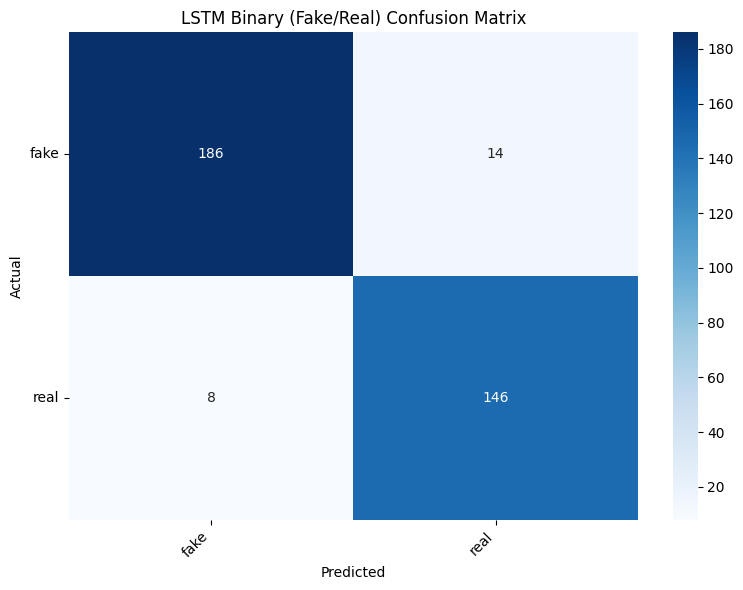


--- Evaluating LSTM Multiclass (News Type) ---
Model loaded successfully from lstm_multi_best.keras
Generating predictions on test data...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Multiclass predictions generated.

Accuracy: 0.8249

Classification Report:
              precision    recall  f1-score   support

    business       0.77      0.80      0.78        50
   political       0.75      0.76      0.75        75
  scientific       0.93      0.82      0.87        76
   spiritual       0.99      0.88      0.93        78
      sports       0.72      0.85      0.78        75

    accuracy                           0.82       354
   macro avg       0.83      0.82      0.82       354
weighted avg       0.84      0.82      0.83       354


Confusion Matrix:


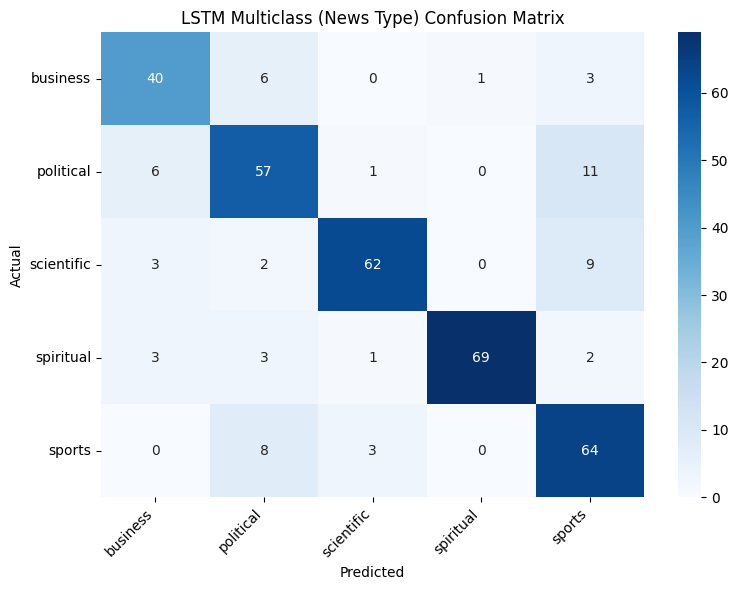


--- LSTM Model Evaluation Summary ---
LSTM Binary Accuracy:   0.9379
LSTM Multiclass Accuracy: 0.8249
-----------------------------------


In [8]:
# --- Step 5: Evaluate LSTM Models ---

import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# --- Evaluation Function ---
def evaluate_lstm_model(model_path, X_test_data, y_test_true, target_names, model_type="LSTM Model"):
    """Loads a saved Keras model and evaluates it on test data."""
    print(f"\n--- Evaluating {model_type} ---")
    # Load the best saved model
    try:
        # Use tf.keras.models.load_model
        model = tf.keras.models.load_model(model_path)
        print(f"Model loaded successfully from {model_path}")
    except Exception as e:
        print(f"Error loading model {model_path}: {e}")
        return 0.0 # Return 0 accuracy if loading fails

    # Make predictions on the test set
    print("Generating predictions on test data...")
    y_pred_proba = model.predict(X_test_data)

    # Convert probabilities to class predictions
    if y_pred_proba.shape[-1] == 1: # Binary classification
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()
        print("Binary predictions generated.")
    else: # Multiclass classification
        y_pred = np.argmax(y_pred_proba, axis=1)
        print("Multiclass predictions generated.")

    # Calculate and print metrics
    acc = accuracy_score(y_test_true, y_pred)
    print(f"\nAccuracy: {acc:.4f}")
    print("\nClassification Report:")
    # Use zero_division=0 to handle cases where a class might have no predictions
    print(classification_report(y_test_true, y_pred, target_names=target_names, zero_division=0))

    # Plot confusion matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test_true, y_pred)
    plt.figure(figsize=(8, 6)) # Adjust size as needed
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'{model_type} Confusion Matrix')
    # Adjust layout if labels overlap
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return acc # Return accuracy

# --- Check if test data exists ---
try:
    X_test_pad
    y_test_binary
    y_test_multi
    binary_classes
    multi_classes
except NameError:
    print("Error: Test data (X_test_pad, etc.) or class names not defined.")
    print("Ensure Steps 1 and 2 ran successfully.")
    exit()

# --- Evaluate Binary LSTM Model ---
acc_lstm_binary = evaluate_lstm_model(
    'lstm_binary_best.keras',       # Path where best binary model was saved
    X_test_pad,                     # Test data from Step 2
    y_test_binary,                  # True binary labels for test set
    binary_classes,                 # Class names ('fake', 'real') from Step 1
    "LSTM Binary (Fake/Real)"
)

# --- Evaluate Multiclass LSTM Model ---
acc_lstm_multi = evaluate_lstm_model(
    'lstm_multi_best.keras',        # Path where best multiclass model was saved
    X_test_pad,                     # Test data from Step 2
    y_test_multi,                   # True multiclass labels for test set
    multi_classes,                  # News type names from Step 1
    "LSTM Multiclass (News Type)"
)

# --- Final Summary ---
print("\n--- LSTM Model Evaluation Summary ---")
print(f"LSTM Binary Accuracy:   {acc_lstm_binary:.4f}")
print(f"LSTM Multiclass Accuracy: {acc_lstm_multi:.4f}")
print("-" * 35)
